### Configurable Variables
Variables that can be modified in this notebook or None
- `qval` - qvalue threshold to filter SVGs or None
- `fsv` - FSV threshold to filter SVGs
- `input_data` — path to the input folder containing the dataset
- `supress_warnings` — boolean flag to enable/disable warning messages (`True`/`False`)
---
**Set following variables if you are running notebook interactively.**

In [64]:
qval_default = 0.05
fsv_default = None
input_path_folder_default = "somde_results/SN048_A121573_Rep1/"
suppress_warnings_default = False

### Load variables from CMD

In [65]:
SUPPRESS_WARNINGS = None
try:
    if suppress_warnings == "True":
        SUPPRESS_WARNINGS = True
    else:
        SUPPRESS_WARNINGS = False
except NameError:
    SUPPRESS_WARNINGS = suppress_warnings_default

try:
    QVAL_TH = qval
except NameError:
    QVAL_TH = qval_default

try:
    FSV_TH = fsv
except NameError:
    FSV_TH = fsv_default

## Suppress Warnings (Optional)

* Suppress warnings for cleaner output.
* Comment out the line below if warnings are desired for debugging.

In [14]:
# Suppress warnings for cleaner output
import warnings
import os

if SUPPRESS_WARNINGS:
    print("Ignoring warnings.")
    warnings.filterwarnings('ignore')

### Environment setup

1. Install the necessary packages using `pip` if they are not already installed:

In [15]:
!pip install matplotlib pandas numpy seaborn matplotlib_venn --quiet
%matplotlib inline


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


2. Import necessary libraries:

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import sys
import os

3. load the dataset
  * **Option 1**: Import data directly from Google Drive (requires Google Colab).
  * **Option 2**: Load dataset path from CMD.

In [17]:
# OPTION 1
# from google.colab import drive
# drive.mount('/content/drive')

In [68]:
# OPTION 2
DATA_PATH = None
try:
    DATA_PATH = input_data_folder
except NameError:
    DATA_PATH = input_path_folder_default

if DATA_PATH is None or not os.path.exists(DATA_PATH):
    print("ERROR: Datapath (", DATA_PATH ,") not found.")
    sys.exit()

print("Using input path:", DATA_PATH)

DATA_FOLDER_NAME = DATA_PATH.split("/")[-2].strip()
output_dir = os.path.join("figures/show/method_comparison/" + DATA_FOLDER_NAME)
os.makedirs(output_dir, exist_ok=True)

os.makedirs("method_comparison/" + DATA_FOLDER_NAME, exist_ok=True)

Using input path: somde_results/SN048_A121573_Rep1/


### Load data

In [69]:
somde_res = pd.read_csv("somde_results/" + DATA_FOLDER_NAME + "/somde_result.csv")
spatialde_res = pd.read_csv("spatialde_results/" + DATA_FOLDER_NAME + "/results.csv")

### Select spatially variable genes
Filter by your dataset

In [70]:
if QVAL_TH is not None and FSV_TH is not None:
    somde_sig = somde_res[(somde_res["qval"] <= QVAL_TH) & (somde_res["FSV"] >= FSV_TH)]["g"]
    spatialde_sig = spatialde_res[(spatialde_res["qval"] <= QVAL_TH) & (spatialde_res["FSV"] >= FSV_TH)]["g"]

elif FSV_TH is not None:
    somde_sig = somde_res[somde_res["FSV"] >= FSV_TH]["g"]
    spatialde_sig = spatialde_res[spatialde_res["FSV"] >= FSV_TH]["g"]

elif QVAL_TH is not None:
    somde_sig = somde_res[somde_res["qval"] <= QVAL_TH]["g"]
    spatialde_sig = spatialde_res[spatialde_res["qval"] <= QVAL_TH]["g"]

else:
    somde_sig = somde_res["g"]
    spatialde_sig = spatialde_res["g"]

set_somde = set(somde_sig)
set_spatialde = set(spatialde_sig)

print("SOMDE number of spatially variable genes: ", len(set_somde))
print("SPATIALDE number of spatially variable genes: ", len(set_spatialde))

SOMDE number of spatially variable genes:  5877
SPATIALDE number of spatially variable genes:  6999


# Method comparison plots

### Venn diagram

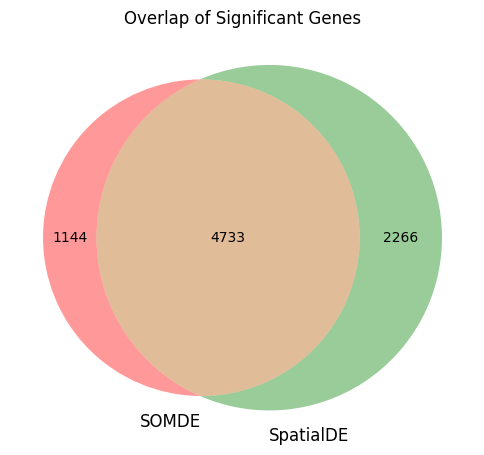

Venn diagram counts saved tomethod_comparison/SN048_A121573_Rep1/venn_counts.csv


In [72]:
plt.figure(figsize=(6, 6))
venn2([set_somde, set_spatialde], set_labels=("SOMDE", "SpatialDE"))
plt.title("Overlap of Significant Genes")
plt.savefig("figures/show/method_comparison/" + DATA_FOLDER_NAME + "/venn_diagram.png", dpi=300, bbox_inches='tight')
plt.show()

only_somde = set_somde - set_spatialde
only_spatialde = set_spatialde - set_somde
both = set_somde & set_spatialde
venn_df = pd.DataFrame({
    "Category": ["Only SOMDE", "Only SpatialDE", "Both"],
    "Count": [len(only_somde), len(only_spatialde), len(both)]
})
venn_df.to_csv("method_comparison/" + DATA_FOLDER_NAME + "/venn_counts.csv", index=False)
print("Venn diagram counts saved to" + "method_comparison/" + DATA_FOLDER_NAME + "/venn_counts.csv")

### Scatter Plot

In [73]:
def classify_gene(g):
    in_somde = g in set_somde
    in_spatialde = g in set_spatialde

    if in_somde and not in_spatialde:
        return "Only SOMDE"
    elif in_spatialde and not in_somde:
        return "Only SpatialDE"
    elif (not in_somde) and (not in_spatialde):
        return "None"
    else:
        return None   # this is the "Both" category → exclude


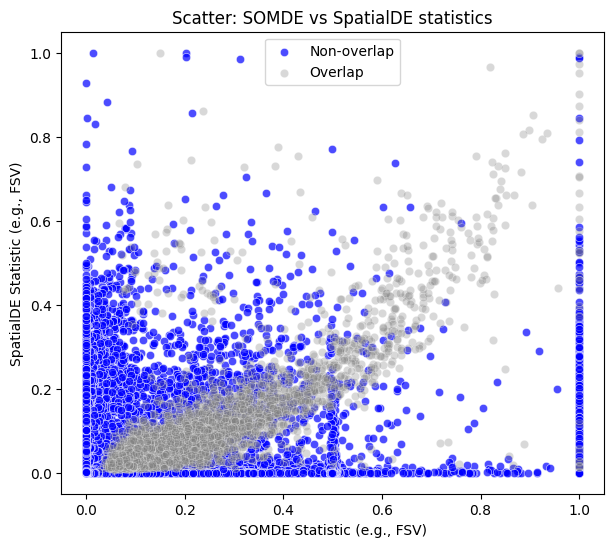

In [80]:
merged = pd.merge(somde_res, spatialde_res, on="g", suffixes=("_somde", "_spatialde"))
merged["overlap"] = merged["g"].isin(set_somde & set_spatialde)

plt.figure(figsize=(7, 6))

# Plot blue points first (non-overlap)
sns.scatterplot(
    data=merged[merged["overlap"] == False],
    x="FSV_somde",
    y="FSV_spatialde",
    color="blue",
    alpha=0.7,           # transparency
    label="Non-overlap"
)

# Plot red points on top (overlap)
sns.scatterplot(
    data=merged[merged["overlap"] == True],
    x="FSV_somde",
    y="FSV_spatialde",
    color="gray",
    alpha=0.3,           # solid
    label="Overlap"
)

plt.title("Scatter: SOMDE vs SpatialDE statistics")
plt.xlabel("SOMDE Statistic (e.g., FSV)")
plt.ylabel("SpatialDE Statistic (e.g., FSV)")
plt.legend()
plt.savefig("figures/show/method_comparison/" + DATA_FOLDER_NAME + "/scatter.overlap.png", dpi=300, bbox_inches='tight')
plt.show()


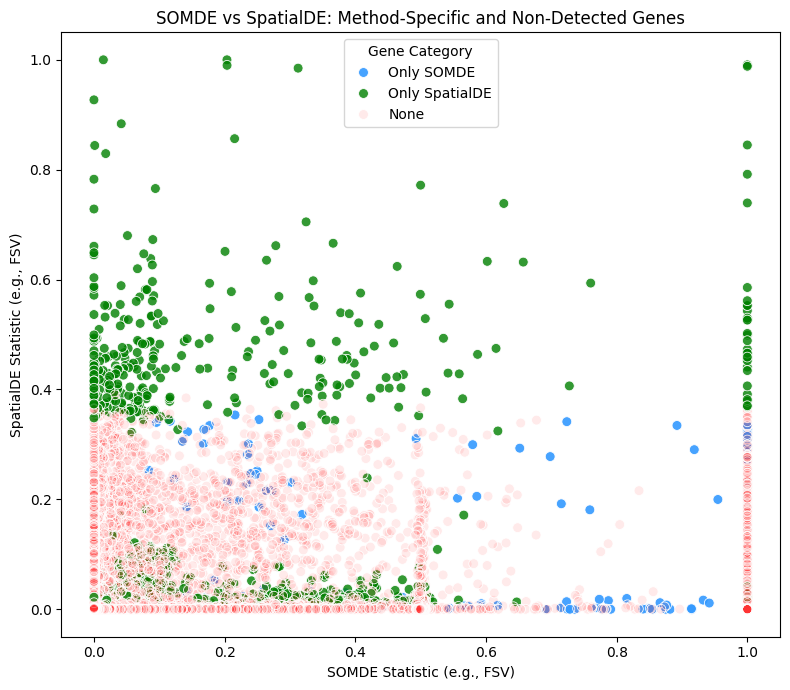

In [84]:
merged["category"] = merged["g"].apply(classify_gene)
plot_data = merged[merged["category"].notna()] # keep 3 categories (exclude None category)

plt.figure(figsize=(8, 7))

palette = {
    "Only SOMDE": (0.2, 0.6, 1.0, 0.9),     # blue
    "Only SpatialDE": (0.0, 0.5, 0.0, 0.8), # green
    "None": (1.0, 0.2, 0.2, 0.1)           # transparent red
}

sns.scatterplot(
    data=plot_data,
    x="FSV_somde",
    y="FSV_spatialde",
    hue="category",
    palette=palette,
    s=50
)

plt.title("SOMDE vs SpatialDE: Method-Specific and Non-Detected Genes")
plt.xlabel("SOMDE Statistic (e.g., FSV)")
plt.ylabel("SpatialDE Statistic (e.g., FSV)")
plt.legend(title="Gene Category")
plt.tight_layout()
plt.savefig("figures/show/method_comparison/" + DATA_FOLDER_NAME + "/scatter.somde_vs_spatialde.png", dpi=300, bbox_inches='tight')
plt.show()


In [52]:
gene_to_check = "CEP83"

if gene_to_check in merged.index:
    row = merged.set_index("gene").loc[gene_to_check]
    print("SOMDE:", row["FSV_somde"])
    print("SpatialDE:", row["FSV_spatialde"])
else:
    print("Tento gen nebyl nalezen.")

Tento gen nebyl nalezen.
